# Cancelamento de Clientes - Telco (dataset criado pela IBM para demonstração da ferramenta IBM Cognos Analytics)

### Contém informações sobre uma empresa fictícia de telecomunicações que forneceu serviços de telefonia residencial e internet para 7043 clientes na Califórnia no 3º trimestre.

### Etapa de testes e validação do modelo - Realizado por Sabrina Otoni da Silva - 2024/01

### Objetivo: Validar o melhor modelo com os respectivos parâmetros listados na etapa anterior para refinamento das predições e testes. 

In [1]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

import sys
import os

automations_dir = os.path.join(os.getcwd(), '../automations')

if automations_dir not in sys.path:
    sys.path.append(automations_dir)

from data_processing import LogTransformer, RBFTransformer, KMeansCluster, DropColumns, ServiceTransformer, CategoricalEncoder

import warnings

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
datapath = Path('../data')
csv_path = Path(f'{datapath}/d02_intermediate')

In [4]:
X_train = pd.read_csv(f'{csv_path}/X_train.csv')
y_train = pd.read_csv(f'{csv_path}/y_train.csv').squeeze()

In [5]:
weights_classes = compute_sample_weight(class_weight='balanced', y=y_train)

Dando peso as classes, pois o conjunto de dados é desbalanceado.

In [6]:
models_info = pd.read_csv(f'{datapath}/d04_models/score_models.csv')
models_info

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_categorical_encoder__encoder_type,param_kmeans_cluster__active,param_model,param_rbf__active,param_scaler,param_service_transformer__encoder_type,param_transformation,param_model__C,param_model__class_weight,param_model__fit_intercept,param_model__booster,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.391582,0.056593,0.132938,0.021243,onehot,True,DummyClassifier(strategy='most_frequent'),True,StandardScaler(),onehot,"LogTransformer(columns=['Total Charges'],\n ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'categorical_encoder__encoder_type': 'onehot'...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,2881
1,0.163052,0.016638,0.105448,0.012171,onehot,True,LogisticRegression(),True,StandardScaler(),label,"LogTransformer(columns=['Total Charges'],\n ...",0.1,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,{'categorical_encoder__encoder_type': 'onehot'...,0.858750,0.862933,0.857959,0.854166,0.871080,0.860978,0.005768,267
2,0.181935,0.037978,0.082483,0.025461,label,True,"XGBClassifier(base_score=None, booster='gbtree...",False,StandardScaler(),label,"LogTransformer(columns=['Total Charges'],\n ...",NaN,NaN,NaN,gbtree,0.6,0.01,0.1,3.0,0.8,"{'categorical_encoder__encoder_type': 'label',...",0.859884,0.866093,0.861707,0.858520,0.871199,0.863481,0.004628,1


In [7]:
models_info[['param_model', 'params']]

,param_model,params
0,DummyClassifier(strategy='most_frequent'),{'categorical_encoder__encoder_type': 'onehot'...
1,LogisticRegression(),{'categorical_encoder__encoder_type': 'onehot'...
2,"XGBClassifier(base_score=None, booster='gbtree...","{'categorical_encoder__encoder_type': 'label',..."


In [8]:
models_info['params'][0]

"{'categorical_encoder__encoder_type': 'onehot', 'kmeans_cluster__active': True, 'model': DummyClassifier(strategy='most_frequent'), 'rbf__active': True, 'scaler': StandardScaler(), 'service_transformer__encoder_type': 'onehot', 'transformation': LogTransformer(columns=['Total Charges'],\n               model_path='../preprocessing/log_transformer_model.pkl')}"

In [9]:
pipeline_dummy = Pipeline([
    ('kmeans_cluster', KMeansCluster(model_path='../preprocessing/kmeans_model.pkl', columns_cluster=['Latitude', 'Longitude'])),
    ('import_drop', DropColumns(drop_columns=["City", "Latitude", "Longitude", "ID"])),
    ('service_transformer', ServiceTransformer(["Multiple Lines", "Online Security", "Online Backup", "Device Protection", "Tech Support",
                                                     "Streaming TV", "Streaming Movies"])),
    ('categorical_encoder', CategoricalEncoder(encoder_type='onehot', specified_columns=["Gender", "Senior Citizen", "Partner", "Dependents",
                                                                                                    "Phone Service", "Multiple Lines", "Internet Service",
                                                                                                    "Online Security", "Online Backup", "Device Protection",
                                                                                                    "Tech Support", "Streaming TV", "Streaming Movies", 
                                                                                                    "Contract", "Paperless Billing", "Payment Method",
                                                                                                    "Cluster"])),
    ('log_transformation', LogTransformer(model_path='../preprocessing/log_transformer_model.pkl', columns=['Total Charges'])),
    ('rbf_transformer', RBFTransformer(column='Tenure Months', model_path='../preprocessing/rbf_transformer_model.pkl')),
    ('scaler', StandardScaler()),
    ('model', DummyClassifier(strategy='most_frequent'))
])

In [10]:
models_info['params'][2]

"{'categorical_encoder__encoder_type': 'label', 'kmeans_cluster__active': True, 'model': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.6, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=0.01, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.1, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=3, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              multi_strategy=None, n_estimators=None, n_jobs=None,\n              num_parallel_tree=None, random_state=None, ...), 'model__booster': 'gbtree', 'model__colsample_bytree': 0.6, 'model__gamma': 0.01, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__s

In [11]:
pipeline_xgboost = Pipeline([
    ('kmeans_cluster', KMeansCluster(model_path='../preprocessing/kmeans_model.pkl', columns_cluster=['Latitude', 'Longitude'])),
    ('import_drop', DropColumns(drop_columns=["City", "Latitude", "Longitude", "ID"])),
    ('categorical_encoder', CategoricalEncoder(encoder_type='label', specified_columns=["Gender", "Senior Citizen", "Partner", "Dependents",
                                                                                                    "Phone Service", "Multiple Lines", "Internet Service",
                                                                                                    "Online Security", "Online Backup", "Device Protection",
                                                                                                    "Tech Support", "Streaming TV", "Streaming Movies", 
                                                                                                    "Contract", "Paperless Billing", "Payment Method",
                                                                                                    "Cluster"])),
    ('log_transformation', LogTransformer(model_path='../preprocessing/log_transformer_model.pkl', columns=['Total Charges'])),
    # ('scaler', StandardScaler()),
    ('model', XGBClassifier(objective='binary:logistic', booster='gbtree', learning_rate=0.1, gamma=0.01, max_depth=3, subsample=0.8, colsample_bytree=0.6, sample_weight=weights_classes))
])

In [12]:
model_metrics = {}

def calculate_metrics(pipeline, X, y, model_name):
    
    metrics = {
        'Precision': cross_val_score(pipeline, X, y, cv=StratifiedKFold(), scoring='precision').mean(),
        'Recall': cross_val_score(pipeline, X, y, cv=StratifiedKFold(), scoring='recall').mean(),
        'F1 Score': cross_val_score(pipeline, X, y, cv=StratifiedKFold(), scoring='f1').mean(),
        'ROC AUC Score': cross_val_score(pipeline, X, y, cv=StratifiedKFold(), scoring='roc_auc').mean()
    }
    
    model_metrics[model_name] = metrics

In [13]:
for model_name, pipeline in [('Dummy', pipeline_dummy), ('XGBoost', pipeline_xgboost)]:
    calculate_metrics(pipeline, X_train, y_train, model_name)

In [14]:
model_metrics

{'Dummy': {'Precision': 0.0,
  'Recall': 0.0,
  'F1 Score': 0.0,
  'ROC AUC Score': 0.5},
 'XGBoost': {'Precision': 0.6775437907278095,
  'Recall': 0.5542774414319557,
  'F1 Score': 0.6094662329486134,
  'ROC AUC Score': 0.8634806918269178}}

Verificando o trade-off de precision/recall para definir o threshold das predições do modelo e refinar ainda mais para o modelo pegar melhor as classes positivas mesmo que isso afete a precisão.

In [15]:
y_probas_dummy = cross_val_predict(pipeline_dummy, X_train, y_train, cv=StratifiedKFold(n_splits=5), method="predict_proba")
y_scores_dummy = y_probas_dummy[:, 1]
precisions_dummy, recalls_dummy, thresholds_dummy = precision_recall_curve(y_train, y_scores_dummy)

In [16]:
y_probas_xgb = cross_val_predict(pipeline_xgboost, X_train, y_train, cv=StratifiedKFold(n_splits=5), method="predict_proba")
y_scores_xgb = y_probas_xgb[:, 1]
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train, y_scores_xgb)

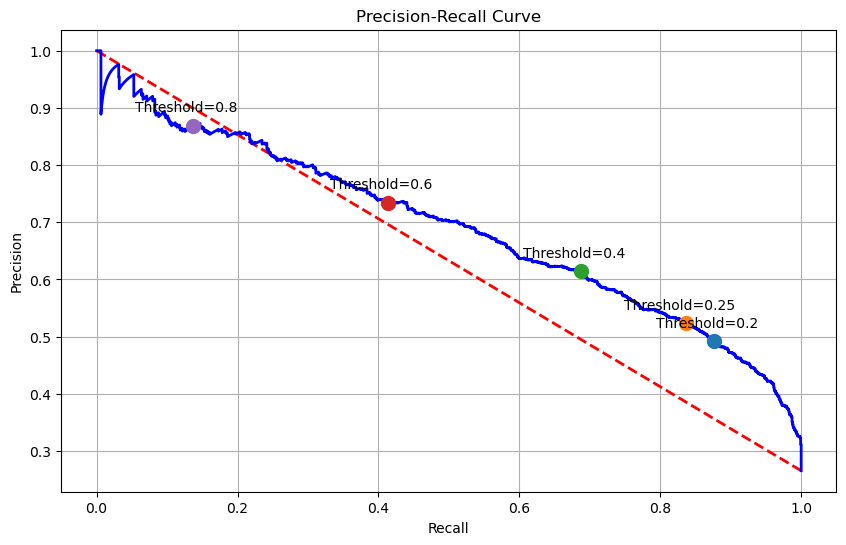

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(recalls_dummy, precisions_dummy, "--", linewidth=2, label="Dummy", color='red')
plt.plot(recalls_xgb, precisions_xgb, "b-", linewidth=2, label="XGBoost", color='blue')

for threshold in [0.2, 0.25, 0.4, 0.6, 0.8]:
    index = (thresholds_xgb >= threshold).argmax()
    plt.plot(recalls_xgb[index], precisions_xgb[index], "o", markersize=10)
    plt.annotate(f"Threshold={threshold}", (recalls_xgb[index], precisions_xgb[index]), textcoords="offset points", xytext=(-5,10), ha='center')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [18]:
limiar = 0.25
y_pred_threshold = (y_scores_xgb >= limiar).astype(int)
cm = confusion_matrix(y_train, y_pred_threshold)
tn, fp, fn, tp = cm.ravel()

print(f"Para o limiar {limiar}:")
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (TP): {tp}")
print(f"Recall: {tp / (tp + fn)}")
print(f"Precisão: {tp / (tp + fp)}")

Para o limiar 0.25:
Verdadeiros Negativos (TN): 2623
Falsos Positivos (FP): 999
Falsos Negativos (FN): 213
Verdadeiros Positivos (TP): 1095
Recall: 0.8371559633027523
Precisão: 0.5229226361031518


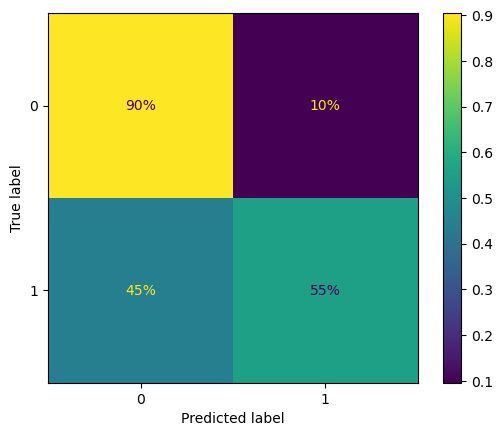

In [19]:
ConfusionMatrixDisplay.from_predictions(y_train, cross_val_predict(pipeline_xgboost, X_train, y_train, cv=StratifiedKFold(n_splits=5)), normalize='true', values_format='.0%')
plt.show()

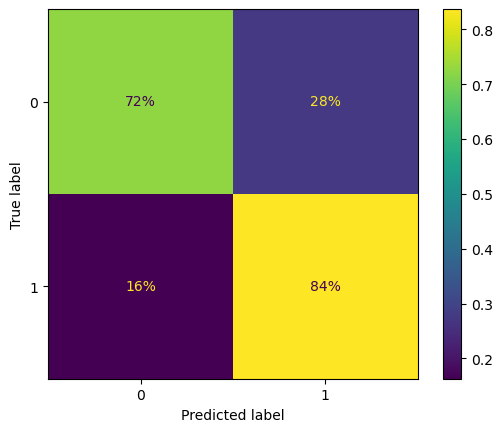

In [20]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_threshold, normalize='true', values_format='.0%')
plt.show()

Podemos ver que as predições para a classe 1 melhoraram muito mais depois de configurar o threshold dando mais ênfase no recall. Acabamos comprometendo a precisão mas como dito anteriormente, foi acordado que seria melhor ter mais falsos positivos do que falsos negativos dado o case que estamos trabalhando.